# Preview ETL — Análisis exploratorio y diseño del pipeline

Este cuaderno documenta el **análisis exploratorio** de los datos provenientes de NewsAPI y cómo se diseñó la **ETL (Extract → Transform → Load)** del proyecto. 

## Parámetros y configuración
Leemos variables de entorno (sin exponerlas en el cuaderno) y preparamos imports.

In [ ]:
import os, sys, pandas as pd
from datetime import datetime, timedelta, timezone

# Asegurar que el proyecto esté en el path
PROJECT_ROOT = '.'
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Lectura segura de variables de entorno
NEWSAPI_KEY = os.getenv('NEWSAPI_KEY')
API_URL = os.getenv('API_URL', 'https://newsapi.org/v2/everything')
DATABASE_URL = os.getenv('DATABASE_URL')  # puede ser None durante el preview

print('API_URL =', API_URL)
print('NEWSAPI_KEY presente =', bool(NEWSAPI_KEY))
print('DATABASE_URL presente =', bool(DATABASE_URL))

API_URL = https://newsapi.org/v2/everything
NEWSAPI_KEY presente = True
DATABASE_URL presente = True


## Extracción de los datos (Extract)

Para la prueba técnica se requiere el uso de la API https://newsapi.org/, por ello usamos requests para poder recoger la información, con los parametros que la documentación solicita.

In [ ]:
import requests

# Creamos una querie para buscar por términos referidos a IA y Marketing
queries = """
    ("AI" OR "artificial intelligence" OR "machine learning" OR "deep learning" OR "neural networks" OR "large language model" OR "LLM" OR "generative AI" OR "ChatGPT") AND ("marketing" OR "digital marketing" OR "content marketing" OR "marketing automation" OR "growth marketing" OR "growth hacking" OR "social media" OR "social media marketing" OR "SEO" OR "SEM" OR "email marketing")
"""

now = datetime.now(timezone.utc)
frm = (now - timedelta(days=7)).isoformat(timespec="seconds")
to = now.isoformat(timespec="seconds")

params = {
    "apiKey": NEWSAPI_KEY,
    "q": queries,
    "page": 1, # Por limitaciones del pricing de la API solo podemos llamar a una página en el mismo momento
    "pageSize": 100,
    "from": frm,
    "to": to
}

try:
    response = requests.get(API_URL, params=params, timeout=30)
    data = response.json()

    news_df = pd.json_normalize(data=data.get("articles"))
except requests.exceptions.RequestException as e:
    print(f"error_message: Error de conexión: {str(e)}")

## Transformación de datos (Transform)

Se analiza la información y se determina una limpieza sencilla de los datos, ya que la información proveniente de la API ya se encuentra "limpia". Se proponen limpiezas de vacíos, normalización del campo Fecha, eliminación de duplicidad por URL de noticia y cumplimentar noticias sin Autor identificado por Anónimo

También se ha realizado un filtro por longitud de contenido, valorando que articulos por debajo de 1000 palabras no se un artículo relevante.

In [ ]:
import pandas as pd
import re

cols_out = [
    "url", "title", "description", "content", "author",
    "published_at", "url_to_image", "source_id", "source_name"
]

df = news_df.copy()

# Asegurar columnas obligatorias
for c in ["title", "description", "publishedAt"]:
    if c not in df.columns:
        df[c] = pd.NA

# Limpiar espacios y nulos en columnas clave
for c in ["title", "description", "content", "author", "url", "urlToImage", "source_id", "source_name"]:
    if c in df.columns:
        df[c] = df[c].fillna("").astype(str).str.strip()

# Rellenar autores vacíos
if "author" not in df.columns:
    df["author"] = "Anonimo"
df.loc[df["author"] == "", "author"] = "Anonimo"

# Eliminar filas sin URL y generar hash de URL normalizada
df = df.drop_duplicates(subset=["url"])

# Convertir fechas a UTC
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce", utc=True)

# Filtrar registros sin campos obligatorios
mask_ok = (
    df["title"].ne("") &
    df["description"].ne("") &
    df["publishedAt"].notna()
)
df = df[mask_ok].copy()

# Filtrar contenido a mas de 1000 caracteres
m = re.search(r"\[\+(\d+)\s+chars\]", df["content"])
extra_chars = int(m.group(1)) if m else 0
df["extra_chars"] = df["content"].apply(extra_chars)
df["content_len"] = df["content"].fillna("").str.len() + df["extra_chars"]

df[df["content_len"] >= 1000].reset_index(drop=True)

# Renombrar columnas
df = df.rename(columns={"publishedAt": "published_at", "urlToImage": "url_to_image"})

# Asegurar que todas las columnas de salida existan
for c in cols_out:
    if c not in df.columns:
        df[c] = pd.NA

## Carga de Datos (Load)

Para este proyecto, se ha tomado la decisión de usar una base de datos relacional PostgresSQL, la idea principal de usar una base de datos relacional, se sustenta en el futuro posible de un proyecto de dichas características el cuál según mi consideración podría albergar relaciones de tablas, como por ejemplo un modelo relacional como el siguiente.

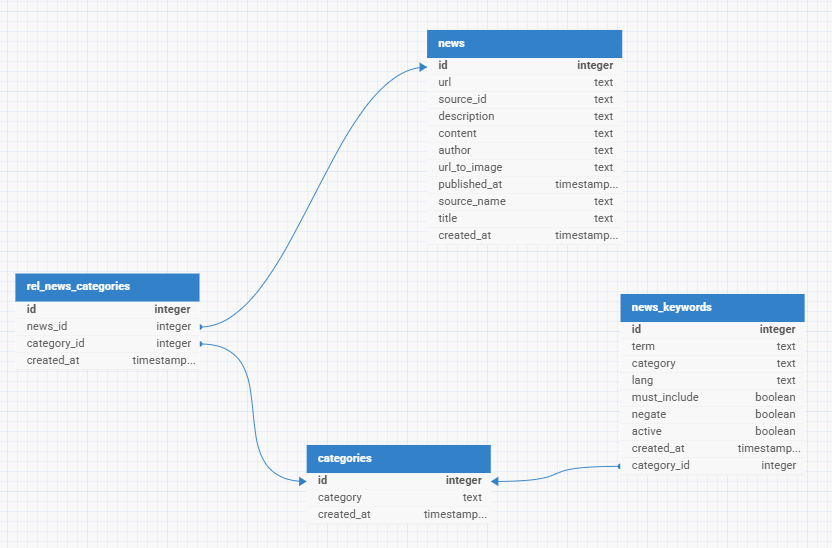